In [2]:
from scripts.load_and_preprocess import (
    make_fsc_from_raw_sct,
    get_data_paths,
    get_sample_number,
    get_datetime,
    get_sysmex_channel_name,
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

from tqdm import tqdm

In [3]:
# get interval and strides sample numbers
interval_sample_nos_36 = np.load(
    "data/raw/interval_baseline_centile_samples_36.npy", allow_pickle=True
)
interval_sample_nos_41 = np.load(
    "data/raw/interval_baseline_centile_samples_41.npy", allow_pickle=True
)
strides_sample_nos = np.load("data/raw/strides_centile_samples.npy", allow_pickle=True)

In [4]:
interval_36_dict = get_data_paths("data/raw/INTERVAL_36", qc_only=False)
interval_41_dict = get_data_paths("data/raw/INTERVAL_41", qc_only=False)
strides_dict = get_data_paths("data/raw/STRIDES", qc_only=False)

In [5]:
interval_36_rets = interval_36_dict["sct_ret"]
interval_41_rets = interval_41_dict["sct_ret"]
strides_rets = strides_dict["sct_ret"]

interval_36_rets_centre = [
    x for x in interval_36_rets if get_sample_number(x) in interval_sample_nos_36
]
interval_41_rets_centre = [
    x for x in interval_41_rets if get_sample_number(x) in interval_sample_nos_41
]
strides_rets_centre = [
    x for x in strides_rets if get_sample_number(x) in strides_sample_nos
]

In [6]:
#! for testing
TESTING = True

if TESTING:
    interval_36_rets = interval_36_rets_centre[:100]
    interval_41_rets = interval_41_rets_centre[:100]
    strides_rets = strides_rets_centre[:100]

In [7]:
interval_36 = []
for filename in tqdm(interval_36_rets):
    df = pd.read_csv(filename)
    interval_36.append(df)

interval_36 = pd.concat(interval_36)

interval_41 = []
for filename in tqdm(interval_41_rets):
    df = pd.read_csv(filename)
    interval_41.append(df)

interval_41 = pd.concat(interval_41)

strides = []
for filename in tqdm(strides_rets):
    df = pd.read_csv(filename)
    strides.append(df)

strides = pd.concat(strides)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 47.79it/s]


(0.0, 50.0)

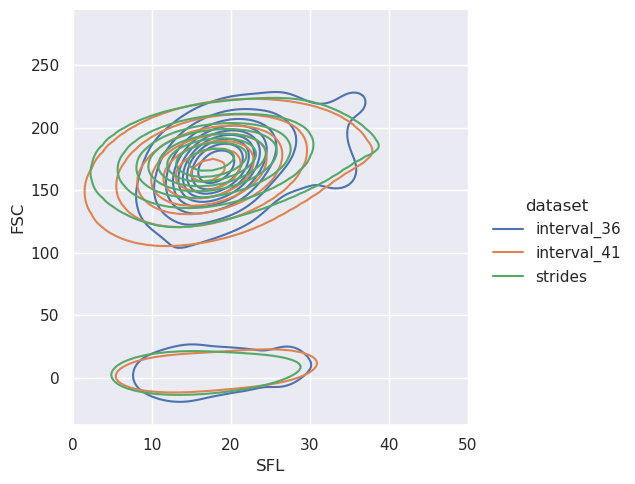

In [8]:
display_df = pd.concat(
    [interval_36.sample(1000), interval_41.sample(1000), strides.sample(1000)]
)
display_df["dataset"] = (
    ["interval_36"] * 1000 + ["interval_41"] * 1000 + ["strides"] * 1000
)

sns.displot(data=display_df, x="SFL", y="FSC", kind="kde", hue="dataset")
plt.xlim(0, 50)

In [ ]:
from sklearn.mixture import GaussianMixture


def fit_RET_gaussian(df):
    gmm = GaussianMixture(
        n_components=3,
        covariance_type="full",
        means_init=[[20, 170], [50, 170], [20, 10]],
    )
    # gmm = GaussianMixture(n_components=10, covariance_type="full")
    X = df[["SFL", "FSC"]].dropna().values
    max_val = X.max()
    # remove saturates (0s and max_val)
    X = X[(X[:, 0] > 0) & (X[:, 0] < max_val) & (X[:, 1] > 0) & (X[:, 1] < max_val)]
    gmm.fit(X)
    return gmm

In [57]:
gmm_interval_36 = fit_RET_gaussian(interval_36)
gmm_interval_41 = fit_RET_gaussian(interval_41)
gmm_strides = fit_RET_gaussian(strides)

In [58]:
gmm_interval_36.means_, gmm_interval_36.covariances_

(array([[ 18.63045456, 168.97845373],
        [ 37.26600047, 179.55270564],
        [ 19.11085879,   5.71772597]]),
 array([[[  10.84956919,   26.69216157],
         [  26.69216157,  226.45130859]],
 
        [[ 334.59649183,  -31.39822395],
         [ -31.39822395, 1683.15728132]],
 
        [[  86.73050173,   35.14139023],
         [  35.14139023,   18.36847766]]]))

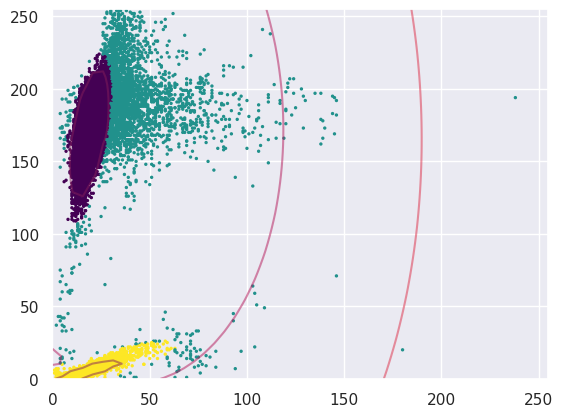

In [59]:
from matplotlib.colors import LogNorm

# display predicted scores by the model as a contour plot
x = np.linspace(0, 255)
y = np.linspace(0, 255)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_interval_36.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X,
    Y,
    Z,
    norm=LogNorm(vmin=1.0, vmax=1000.0),
    levels=np.logspace(0, 3, 10),
    alpha=0.5,
)

X = pd.read_csv(interval_36_rets[0])[["SFL", "FSC"]].dropna().values
max_val = X.max()
# remove saturates (0s and max_val)
X = X[(X[:, 0] > 0) & (X[:, 0] < max_val) & (X[:, 1] > 0) & (X[:, 1] < max_val)]
# downsample X
# X = X[np.random.choice(X.shape[0], 10000, replace=False)]
y = gmm_interval_36.predict(X)
plt.scatter(X[:, 0], X[:, 1], s=2, c=y, cmap="viridis")

In [60]:
from matplotlib.patches import Ellipse


def plot_gaussian_ellipse(ax, mean, cov, color, alpha=0.3):
    """
    Plot the covariance ellipse for a 2D Gaussian
    """
    # Compute eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Compute angle of rotation
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

    # Create ellipse (3 standard deviations)
    ellipse = Ellipse(
        xy=mean,
        width=2 * np.sqrt(eigenvals[0]) * 3,
        height=2 * np.sqrt(eigenvals[1]) * 3,
        angle=angle,
        facecolor=color,
        alpha=alpha,
        edgecolor=color,
        linewidth=2,
    )
    ax.add_patch(ellipse)

    # Plot mean as a cross
    ax.plot(mean[0], mean[1], "x", color=color, markersize=10, markeredgewidth=2)

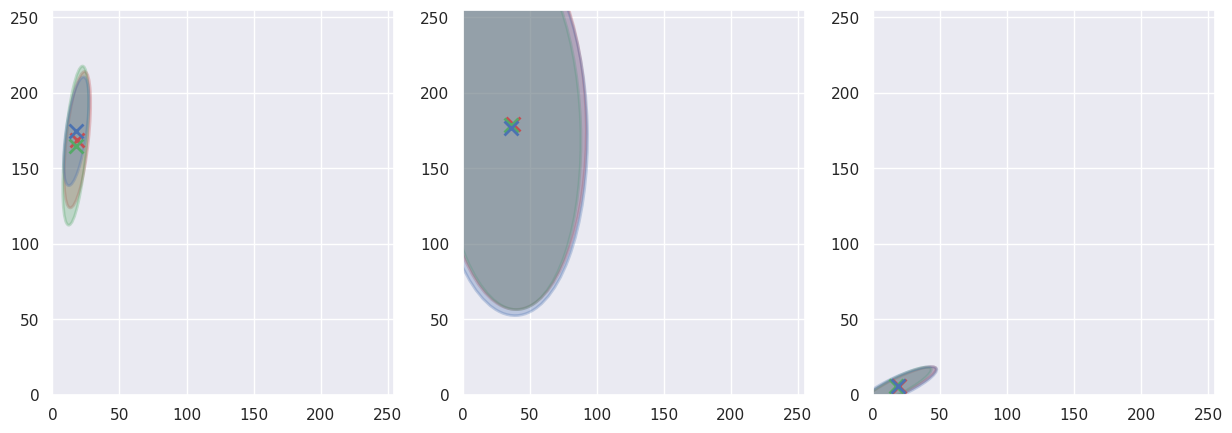

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

axes = ax.flatten()

for i in range(3):
    plot_gaussian_ellipse(
        axes[i], gmm_interval_36.means_[i], gmm_interval_36.covariances_[i], "r"
    )
    plot_gaussian_ellipse(
        axes[i], gmm_interval_41.means_[i], gmm_interval_41.covariances_[i], "g"
    )
    plot_gaussian_ellipse(
        axes[i], gmm_strides.means_[i], gmm_strides.covariances_[i], "b"
    )
    axes[i].set_xlim(0, 255)
    axes[i].set_ylim(0, 255)

In [63]:
def calculate_trafo_from_covs(cov_ref, cov_alt):
    eigenvalues_ref, eigenvectors_ref = np.linalg.eigh(cov_ref)
    eigenvalues_alt, eigenvectors_alt = np.linalg.eigh(cov_alt)

    return (
        eigenvectors_ref
        @ np.diag(np.sqrt(eigenvalues_ref))
        @ eigenvectors_alt.T
        @ np.diag(1 / np.sqrt(eigenvalues_alt))
    )

In [66]:
transformation_41_to_36 = {
    0: {
        "trafo_matrix": calculate_trafo_from_covs(
            gmm_interval_36.covariances_[0], gmm_interval_41.covariances_[0]
        ),
        "mean_ref": gmm_interval_36.means_[0],
        "mean_alt": gmm_interval_41.means_[0],
    },
    1: {
        "trafo_matrix": calculate_trafo_from_covs(
            gmm_interval_36.covariances_[1], gmm_interval_41.covariances_[1]
        ),
        "mean_ref": gmm_interval_36.means_[1],
        "mean_alt": gmm_interval_41.means_[1],
    },
    2: {
        "trafo_matrix": calculate_trafo_from_covs(
            gmm_interval_36.covariances_[2], gmm_interval_41.covariances_[2]
        ),
        "mean_ref": gmm_interval_36.means_[2],
        "mean_alt": gmm_interval_41.means_[2],
    },
}

transformation_strides_to_36 = {
    0: {
        "trafo_matrix": calculate_trafo_from_covs(
            gmm_interval_36.covariances_[0], gmm_strides.covariances_[0]
        ),
        "mean_ref": gmm_interval_36.means_[0],
        "mean_alt": gmm_strides.means_[0],
    },
    1: {
        "trafo_matrix": calculate_trafo_from_covs(
            gmm_interval_36.covariances_[1], gmm_strides.covariances_[1]
        ),
        "mean_ref": gmm_interval_36.means_[1],
        "mean_alt": gmm_strides.means_[1],
    },
    2: {
        "trafo_matrix": calculate_trafo_from_covs(
            gmm_interval_36.covariances_[2], gmm_strides.covariances_[2]
        ),
        "mean_ref": gmm_interval_36.means_[2],
        "mean_alt": gmm_strides.means_[2],
    },
}

In [68]:
def transform_data(X, transformation):
    return (
        transformation["trafo_matrix"] @ (X - transformation["mean_alt"]).T
    ).T + transformation["mean_ref"]

In [69]:
def transform_RET(df, transformation_dict):
    X = df[["SFL", "FSC"]].dropna().values
    max_val = X.max()
    # remove saturates (0s and max_val)
    X = X[(X[:, 0] > 0) & (X[:, 0] < max_val) & (X[:, 1] > 0) & (X[:, 1] < max_val)]
    y = gmm_interval_36.predict(X)
    X_trafo = []
    for i in np.unique(y):
        X_trafo.append(transform_data(X[y == i], transformation_dict[i]))
    return np.concatenate(X_trafo)

In [71]:
strides_trafo = transform_RET(strides, transformation_strides_to_36)

In [74]:
strides_trafo.shape, strides.shape

((6161025, 2), (6192394, 7))

(-50.0, 50.0)

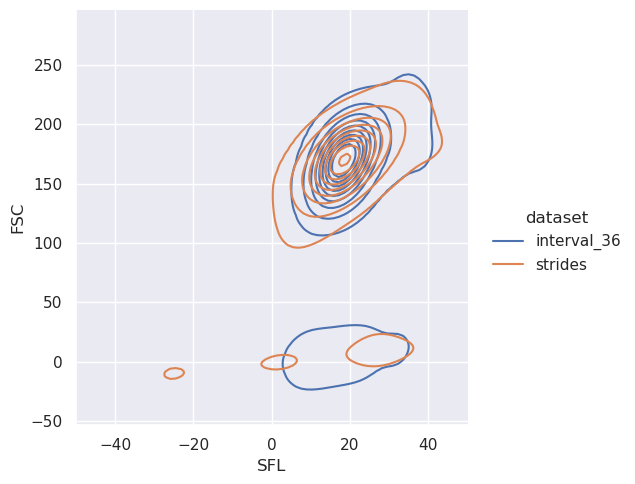

In [ ]:
display_df = pd.concat(
    [
        interval_36.sample(1000),
        # interval_41.sample(1000),
        pd.DataFrame(strides_trafo, columns=["SFL", "FSC"]).sample(1000),
    ]
)

display_df["dataset"] = ["interval_36"] * 1000 + ["strides"] * 1000

sns.displot(data=display_df, x="SFL", y="FSC", kind="kde", hue="dataset")
plt.xlim(-50, 50)

In [ ]:
import flowio


def make_simple_fsc(X, channel_names, save_path: str, metadata: dict):
    data_set = (
        np.vstack(
            [
                X,
            ]
        )
        .flatten()
        .tolist()
    )

    fh = open(save_path, "wb")
    flowio.create_fcs(fh, data_set, channel_names, metadata_dict=metadata)
    fh.close()

In [ ]:
make_simple_fsc(
    strides[["SFL", "FSC"]],
    ["SFL", "FSC"],
    "data/dummy_tests/strides_100_centre.fcs",
    {"transformed": "False"},
)
make_simple_fsc(
    strides_trafo,
    ["SFL", "FSC"],
    "data/dummy_tests/strides_100_centre_trafo.fcs",
    {"transformed": "True"},
)
make_simple_fsc(
    interval_36[["SFL", "FSC"]],
    ["SFL", "FSC"],
    "data/dummy_tests/interval_36_100_centre.fcs",
    {"transformed": "False"},
)